# Introducción

Este notebook entrena un perceptrón multicapa (MLP) para predecir "RENDIMIENTO_GLOBAL" (4 clases: alto, bajo, medio-alto, medio-bajo) a partir de 17 variables numéricas preprocesadas.

- Datos: X (690.861 filas × 17 columnas) y etiquetas one-hot Y; división estratificada en train/val/test (≈80/10/10).
- Reproducibilidad: SEED = 42 para semillas y determinismo parcial.
- Pipeline:
    - Carga de CSV preprocesados.
    - Split estratificado (train/val/test).
    - Cálculo opcional de class weights.
    - Definición de modelo MLP (BatchNorm, Dropout, L2).
    - Compilación y entrenamiento con callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau).
    - Visualización de curvas de pérdida y accuracy.
    - Predicciones sobre conjunto de test y generación de submission (kaggle_submission).

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks, optimizers

# reproducibilidad (no garantiza bit-perfect en GPU, pero es útil)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = 'data'
X_path = os.path.join(DATA_DIR, 'X_preprocessed.csv')
y_path = os.path.join(DATA_DIR, 'y_preprocessed.csv')
y1hot_path = os.path.join(DATA_DIR, 'y_one_hot_preprocessed.csv')

MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(MODEL_DIR, 'best_mlp.h5')


### 2. Se hace la carga de los datos y se aseguran los shapes de cada una de las matrices para evitar errores

In [ ]:
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)
y_onehot = pd.read_csv(y1hot_path)

print("Shapes:", X.shape, y.shape, y_onehot.shape)
y_labels = y.iloc[:, 0].astype(str).values  # textual labels (str)
Y = y_onehot.values.astype(np.float32)     # one-hot numpy (n, 4)

# comprobar n_rows
assert X.shape[0] == Y.shape[0] == y_labels.shape[0], "Los registros no están alineados!"


Shapes: (690861, 17) (690861, 1) (690861, 4)


### 3. Se realiza una separacion de los datos entre train test validation

In [ ]:
TEST_SIZE = 0.10
VAL_SIZE = 0.10  # respecto al total; lo manejaremos en dos pasos

# primero separar test
X_temp, X_test, ytemp_labels, y_test = train_test_split(
    X, Y, test_size=TEST_SIZE, random_state=SEED, stratify=y_labels
)

# ahora de X_temp separamos validation (VAL_SIZE/(1-TEST_SIZE) fracción)
val_fraction_of_temp = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, ytemp_labels, test_size=val_fraction_of_temp, random_state=SEED, stratify=None
)

# Nota: en la primera estratificación usamos y_labels; en el segundo split
# usamos la parte correspondiente de y (ya alineada). Para mayor seguridad

print("Train / Val / Test shapes:", X_train.shape, X_val.shape, X_test.shape)
print("y shapes:", y_train.shape, y_val.shape, y_test.shape)


Train / Val / Test shapes: (552688, 17) (69086, 17) (69087, 17)
y shapes: (552688, 4) (69086, 4) (69087, 4)


In [ ]:
y_indices = np.argmax(Y, axis=1)
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_indices),
                                                  y=y_indices)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(0.9857107391321718), 1: np.float64(1.0008938867994506), 2: np.float64(1.0087093514927814), 3: np.float64(1.0049939775511034)}


Esto muestra que nuetras clases estan casi perfectamente balanceadas, por lo que no habra ningun sesgo respecto al desbalanceo de los datos

### 4.  Creación y entrenamiento del modelo

- Arquitectura (celda de construcción):
    - Entrada de dimensión `input_dim`.
    - Capa densa con regularización L2 (`hidden_units`, `use_bias=False`).
    - BatchNormalization → ReLU → Dropout (`dropout_rate`).
    - Capa de salida densa con softmax de 4 neuronas (4 clases). Modelo: `mlp_simple`.

- Compilación:
    - Optimizer: `Adam(learning_rate=LR)`.
    - Loss: `categorical_crossentropy`.
    - Métrica: `accuracy`.

- Callbacks usados:
    - `EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)`.
    - `ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True)`.
    - `ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)`.

- Entrenamiento (fit):
    - Entrena con `X_train`, `y_train`; validación con `(X_val, y_val)`.
    - Parámetros: `epochs=EPOCHS`, `batch_size=BATCH_SIZE`.
    - Se pueden pasar `class_weight=class_weights_dict` si se desea.
    - El mejor modelo se guarda por `ModelCheckpoint`; al final también se guarda `final_mlp.h5`.

- Post‑entrenamiento:
    - Se visualizan curvas (loss / accuracy) desde `history`.
    - Se hacen predicciones con `model.predict(X_test)` y se obtiene la clase por `argmax`.

In [ ]:
def build_mlp(input_dim, hidden_units=128, dropout_rate=0.3, l2_reg=1e-4):
    inputs = layers.Input(shape=(input_dim,), name='input')
    x = layers.Dense(hidden_units, kernel_regularizer=regularizers.l2(l2_reg), use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(4, activation='softmax', name='output')(x)
    model = models.Model(inputs=inputs, outputs=outputs, name='mlp_simple')
    return model

input_dim = X_train.shape[1]
model = build_mlp(input_dim=input_dim, hidden_units=128, dropout_rate=0.3, l2_reg=1e-4)
model.summary()


Model: "mlp_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,204 (12.52 KB)

 Trainable params: 2,948 (11.52 KB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 50
LR = 1e-3

optimizer = optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
cb_ckpt = callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
cb_rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

history = model.fit(
    X_train.values.astype(np.float32), y_train.astype(np.float32),
    validation_data=(X_val.values.astype(np.float32), y_val.astype(np.float32)),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[cb_early, cb_ckpt, cb_rlrop],
    # si calculaste class_weights arriba, pásalos: class_weight=class_weights_dict
    # class_weight=class_weights_dict,
    verbose=2
)

# Guardar el modelo final (la mejor versión ya fue guardada por ModelCheckpoint)
model.save(os.path.join(MODEL_DIR, 'final_mlp.h5'))


Epoch 1/50

Epoch 1: val_loss improved from None to 1.23775, saving model to models\best_mlp.h5


540/540 - 7s - 13ms/step - accuracy: 0.3834 - loss: 1.3012 - val_accuracy: 0.4148 - val_loss: 1.2378 - learning_rate: 0.0010
Epoch 2/50

Epoch 2: val_loss improved from 1.23775 to 1.23051, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4147 - loss: 1.2369 - val_accuracy: 0.4184 - val_loss: 1.2305 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: val_loss improved from 1.23051 to 1.22859, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4185 - loss: 1.2320 - val_accuracy: 0.4201 - val_loss: 1.2286 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: val_loss improved from 1.22859 to 1.22749, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4195 - loss: 1.2300 - val_accuracy: 0.4196 - val_loss: 1.2275 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: val_loss improved from 1.22749 to 1.22641, saving model to models\best_mlp.h5


540/540 - 4s - 6ms/step - accuracy: 0.4201 - loss: 1.2288 - val_accuracy: 0.4202 - val_loss: 1.2264 - learning_rate: 0.0010
Epoch 6/50

Epoch 6: val_loss improved from 1.22641 to 1.22597, saving model to models\best_mlp.h5


540/540 - 4s - 8ms/step - accuracy: 0.4200 - loss: 1.2279 - val_accuracy: 0.4210 - val_loss: 1.2260 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: val_loss improved from 1.22597 to 1.22538, saving model to models\best_mlp.h5


540/540 - 3s - 5ms/step - accuracy: 0.4201 - loss: 1.2272 - val_accuracy: 0.4209 - val_loss: 1.2254 - learning_rate: 0.0010
Epoch 8/50

Epoch 8: val_loss improved from 1.22538 to 1.22506, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4205 - loss: 1.2268 - val_accuracy: 0.4212 - val_loss: 1.2251 - learning_rate: 0.0010
Epoch 9/50

Epoch 9: val_loss improved from 1.22506 to 1.22444, saving model to models\best_mlp.h5


540/540 - 6s - 12ms/step - accuracy: 0.4208 - loss: 1.2263 - val_accuracy: 0.4216 - val_loss: 1.2244 - learning_rate: 0.0010
Epoch 10/50

Epoch 10: val_loss improved from 1.22444 to 1.22387, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4212 - loss: 1.2258 - val_accuracy: 0.4213 - val_loss: 1.2239 - learning_rate: 0.0010
Epoch 11/50

Epoch 11: val_loss improved from 1.22387 to 1.22359, saving model to models\best_mlp.h5


540/540 - 5s - 9ms/step - accuracy: 0.4213 - loss: 1.2255 - val_accuracy: 0.4215 - val_loss: 1.2236 - learning_rate: 0.0010
Epoch 12/50

Epoch 12: val_loss did not improve from 1.22359
540/540 - 3s - 6ms/step - accuracy: 0.4211 - loss: 1.2251 - val_accuracy: 0.4216 - val_loss: 1.2237 - learning_rate: 0.0010
Epoch 13/50

Epoch 13: val_loss did not improve from 1.22359
540/540 - 4s - 8ms/step - accuracy: 0.4213 - loss: 1.2251 - val_accuracy: 0.4218 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 14/50

Epoch 14: val_loss did not improve from 1.22359

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
540/540 - 4s - 7ms/step - accuracy: 0.4220 - loss: 1.2245 - val_accuracy: 0.4224 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 15/50

Epoch 15: val_loss improved from 1.22359 to 1.22219, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4223 - loss: 1.2237 - val_accuracy: 0.4210 - val_loss: 1.2222 - learning_rate: 5.0000e-04
Epoch 16/50

Epoch 16: val_loss improved from 1.22219 to 1.22208, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4223 - loss: 1.2232 - val_accuracy: 0.4206 - val_loss: 1.2221 - learning_rate: 5.0000e-04
Epoch 17/50

Epoch 17: val_loss improved from 1.22208 to 1.22138, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4227 - loss: 1.2230 - val_accuracy: 0.4220 - val_loss: 1.2214 - learning_rate: 5.0000e-04
Epoch 18/50

Epoch 18: val_loss improved from 1.22138 to 1.22124, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4223 - loss: 1.2226 - val_accuracy: 0.4217 - val_loss: 1.2212 - learning_rate: 5.0000e-04
Epoch 19/50

Epoch 19: val_loss improved from 1.22124 to 1.22113, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4231 - loss: 1.2225 - val_accuracy: 0.4220 - val_loss: 1.2211 - learning_rate: 5.0000e-04
Epoch 20/50

Epoch 20: val_loss did not improve from 1.22113
540/540 - 3s - 6ms/step - accuracy: 0.4230 - loss: 1.2225 - val_accuracy: 0.4220 - val_loss: 1.2211 - learning_rate: 5.0000e-04
Epoch 21/50

Epoch 21: val_loss improved from 1.22113 to 1.22090, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4233 - loss: 1.2224 - val_accuracy: 0.4219 - val_loss: 1.2209 - learning_rate: 5.0000e-04
Epoch 22/50

Epoch 22: val_loss did not improve from 1.22090
540/540 - 3s - 6ms/step - accuracy: 0.4227 - loss: 1.2222 - val_accuracy: 0.4217 - val_loss: 1.2211 - learning_rate: 5.0000e-04
Epoch 23/50

Epoch 23: val_loss did not improve from 1.22090
540/540 - 4s - 7ms/step - accuracy: 0.4229 - loss: 1.2221 - val_accuracy: 0.4226 - val_loss: 1.2211 - learning_rate: 5.0000e-04
Epoch 24/50

Epoch 24: val_loss did not improve from 1.22090

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
540/540 - 4s - 7ms/step - accuracy: 0.4233 - loss: 1.2223 - val_accuracy: 0.4223 - val_loss: 1.2210 - learning_rate: 5.0000e-04
Epoch 25/50

Epoch 25: val_loss improved from 1.22090 to 1.21987, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4236 - loss: 1.2215 - val_accuracy: 0.4225 - val_loss: 1.2199 - learning_rate: 2.5000e-04
Epoch 26/50

Epoch 26: val_loss improved from 1.21987 to 1.21958, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4234 - loss: 1.2212 - val_accuracy: 0.4225 - val_loss: 1.2196 - learning_rate: 2.5000e-04
Epoch 27/50

Epoch 27: val_loss improved from 1.21958 to 1.21950, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4240 - loss: 1.2212 - val_accuracy: 0.4231 - val_loss: 1.2195 - learning_rate: 2.5000e-04
Epoch 28/50

Epoch 28: val_loss did not improve from 1.21950
540/540 - 3s - 6ms/step - accuracy: 0.4234 - loss: 1.2213 - val_accuracy: 0.4221 - val_loss: 1.2196 - learning_rate: 2.5000e-04
Epoch 29/50

Epoch 29: val_loss improved from 1.21950 to 1.21943, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4234 - loss: 1.2210 - val_accuracy: 0.4230 - val_loss: 1.2194 - learning_rate: 2.5000e-04
Epoch 30/50

Epoch 30: val_loss improved from 1.21943 to 1.21925, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4236 - loss: 1.2207 - val_accuracy: 0.4225 - val_loss: 1.2192 - learning_rate: 2.5000e-04
Epoch 31/50

Epoch 31: val_loss improved from 1.21925 to 1.21918, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4237 - loss: 1.2212 - val_accuracy: 0.4226 - val_loss: 1.2192 - learning_rate: 2.5000e-04
Epoch 32/50

Epoch 32: val_loss did not improve from 1.21918
540/540 - 3s - 6ms/step - accuracy: 0.4238 - loss: 1.2211 - val_accuracy: 0.4234 - val_loss: 1.2192 - learning_rate: 2.5000e-04
Epoch 33/50

Epoch 33: val_loss improved from 1.21918 to 1.21914, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4236 - loss: 1.2209 - val_accuracy: 0.4233 - val_loss: 1.2191 - learning_rate: 2.5000e-04
Epoch 34/50

Epoch 34: val_loss improved from 1.21914 to 1.21900, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4236 - loss: 1.2207 - val_accuracy: 0.4236 - val_loss: 1.2190 - learning_rate: 2.5000e-04
Epoch 35/50

Epoch 35: val_loss did not improve from 1.21900
540/540 - 3s - 6ms/step - accuracy: 0.4244 - loss: 1.2207 - val_accuracy: 0.4228 - val_loss: 1.2192 - learning_rate: 2.5000e-04
Epoch 36/50

Epoch 36: val_loss did not improve from 1.21900
540/540 - 4s - 7ms/step - accuracy: 0.4239 - loss: 1.2208 - val_accuracy: 0.4236 - val_loss: 1.2192 - learning_rate: 2.5000e-04
Epoch 37/50

Epoch 37: val_loss improved from 1.21900 to 1.21900, saving model to models\best_mlp.h5



Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
540/540 - 4s - 8ms/step - accuracy: 0.4239 - loss: 1.2205 - val_accuracy: 0.4231 - val_loss: 1.2190 - learning_rate: 2.5000e-04
Epoch 38/50

Epoch 38: val_loss improved from 1.21900 to 1.21853, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4235 - loss: 1.2200 - val_accuracy: 0.4234 - val_loss: 1.2185 - learning_rate: 1.2500e-04
Epoch 39/50

Epoch 39: val_loss improved from 1.21853 to 1.21850, saving model to models\best_mlp.h5


540/540 - 4s - 7ms/step - accuracy: 0.4244 - loss: 1.2199 - val_accuracy: 0.4231 - val_loss: 1.2185 - learning_rate: 1.2500e-04
Epoch 40/50

Epoch 40: val_loss improved from 1.21850 to 1.21839, saving model to models\best_mlp.h5


540/540 - 3s - 5ms/step - accuracy: 0.4239 - loss: 1.2203 - val_accuracy: 0.4234 - val_loss: 1.2184 - learning_rate: 1.2500e-04
Epoch 41/50

Epoch 41: val_loss improved from 1.21839 to 1.21831, saving model to models\best_mlp.h5


540/540 - 4s - 8ms/step - accuracy: 0.4243 - loss: 1.2201 - val_accuracy: 0.4236 - val_loss: 1.2183 - learning_rate: 1.2500e-04
Epoch 42/50

Epoch 42: val_loss improved from 1.21831 to 1.21822, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4240 - loss: 1.2199 - val_accuracy: 0.4239 - val_loss: 1.2182 - learning_rate: 1.2500e-04
Epoch 43/50

Epoch 43: val_loss did not improve from 1.21822
540/540 - 4s - 7ms/step - accuracy: 0.4244 - loss: 1.2200 - val_accuracy: 0.4236 - val_loss: 1.2182 - learning_rate: 1.2500e-04
Epoch 44/50

Epoch 44: val_loss improved from 1.21822 to 1.21817, saving model to models\best_mlp.h5


540/540 - 3s - 5ms/step - accuracy: 0.4241 - loss: 1.2201 - val_accuracy: 0.4236 - val_loss: 1.2182 - learning_rate: 1.2500e-04
Epoch 45/50

Epoch 45: val_loss did not improve from 1.21817

Epoch 45: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
540/540 - 3s - 6ms/step - accuracy: 0.4240 - loss: 1.2201 - val_accuracy: 0.4235 - val_loss: 1.2182 - learning_rate: 1.2500e-04
Epoch 46/50

Epoch 46: val_loss improved from 1.21817 to 1.21798, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4235 - loss: 1.2197 - val_accuracy: 0.4236 - val_loss: 1.2180 - learning_rate: 6.2500e-05
Epoch 47/50

Epoch 47: val_loss did not improve from 1.21798
540/540 - 4s - 8ms/step - accuracy: 0.4247 - loss: 1.2195 - val_accuracy: 0.4234 - val_loss: 1.2180 - learning_rate: 6.2500e-05
Epoch 48/50

Epoch 48: val_loss improved from 1.21798 to 1.21793, saving model to models\best_mlp.h5


540/540 - 3s - 5ms/step - accuracy: 0.4245 - loss: 1.2196 - val_accuracy: 0.4239 - val_loss: 1.2179 - learning_rate: 6.2500e-05
Epoch 49/50

Epoch 49: val_loss improved from 1.21793 to 1.21792, saving model to models\best_mlp.h5



Epoch 49: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
540/540 - 3s - 6ms/step - accuracy: 0.4244 - loss: 1.2196 - val_accuracy: 0.4233 - val_loss: 1.2179 - learning_rate: 6.2500e-05
Epoch 50/50

Epoch 50: val_loss improved from 1.21792 to 1.21787, saving model to models\best_mlp.h5


540/540 - 3s - 6ms/step - accuracy: 0.4247 - loss: 1.2194 - val_accuracy: 0.4237 - val_loss: 1.2179 - learning_rate: 3.1250e-05
Restoring model weights from the end of the best epoch: 50.


### 5. Graficas del entrenamient y desempeño

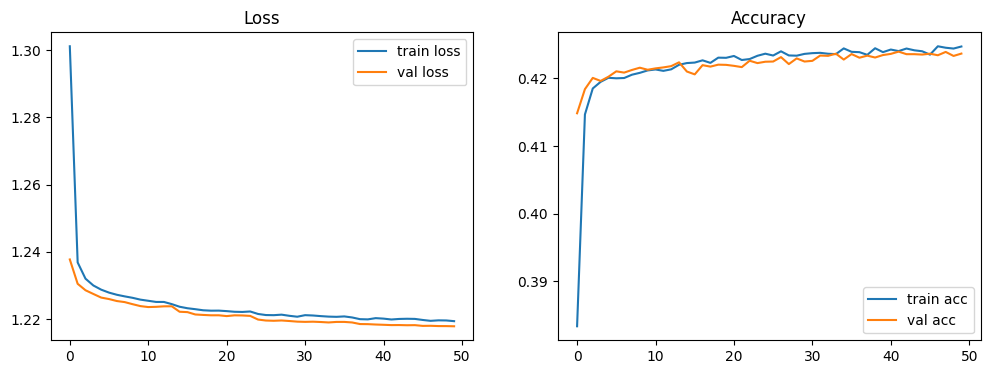

In [9]:
# Cell 7 — curvas
hist = history.history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['loss'], label='train loss')
plt.plot(hist['val_loss'], label='val loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(hist['accuracy'], label='train acc')
plt.plot(hist['val_accuracy'], label='val acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [ ]:
# ejemplo de predicción: devuelve probabilidades y label predicted index
probs = model.predict(X_test.iloc[:10].values.astype(np.float32))
pred_indices = np.argmax(probs, axis=1)
print("pred indices:", pred_indices)

2159/2159 - 7s - 3ms/step - accuracy: 0.4253 - loss: 1.2184
Test loss/acc: [1.2183880805969238, 0.42527538537979126]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
pred indices: [2 2 2 0 1 1 3 0 3 0]


### Interpretación de los resultados

- Rendimiento del modelo
    - Arquitectura: MLP simple (BatchNorm, Dropout, L2) con input_dim = 17.
    - Exactitud final en training y validación ≈ 42% (historia muestra train ≈0.42, val ≈0.42) — por encima del azar (25% para 4 clases) pero todavía insuficiente para una aplicación sólida.
    - Pérdida estable alrededor de 1.22 en train/val; brecha pequeña entre train y val → no hay sobreajuste marcado, más bien capacidad limitada del modelo o de las features.
    - El optimizador y callbacks funcionaron (ReduceLROnPlateau bajó el LR al menos una vez según history).

- Predicciones y output
    - Se generaron probabilidades (predictions) y etiquetas (predictions_integers, rendimiento_global_pred) para ~296k muestras de test; el pipeline de submission está listo.
    - Distribución de probabilidades indica incertidumbre en bastantes casos (valores de probabilidad no concentrados), lo que sugiere características poco discriminativas.

### Conclusiones
El MLP aprende señal útil (≈42% accuracy), pero el rendimiento es todavía moderado para un problema de 4 clases. No hay indicios de sobreajuste; la limitación parece venir de la capacidad del modelo o de las features. Priorizar ingeniería de features y comparar con modelos alternativos (p. ej. árboles de boosting) probablemente dará mayores mejoras.